In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Baseline Consumption-Saving Model - From HANK lecture 1

### Value function, $v_t$: 
Defined recursively from 

$$v_t (z_t , a_{t-1}) = \max_u(c_t) + \beta E_t [v_{t+1}(z_{t+1}, a_t)]$$

subject to:

$$a_t = (1+r)a_{t-1} + w z_t - c_t \geq w b$$ 

### Policy function, $c^*_{t}$: 
Is the same as with $v_T(\cdot) = 0$.

$$c^*_{t}(z_t, a_{t-1}) = \arg \max_u(c_t) + \beta E_t [v_{t+1}(z_{t+1}, a_t)]$$

subject to:

$$a_t = (1+r)a_{t-1} + w z_t - c_t \geq w b$$

$$z_t = \tilde{z}_t \xi_t, \quad \log \xi_t \sim \mathcal{N}(\mu_{\xi}, \sigma_{\xi})$$

$$\log z_{t+1} = \rho_z \log z_t + \psi_{t+1}, \quad \psi_{t+1} \sim \mathcal{N}(\mu_{\psi}, \sigma_{\psi})$$

- $v_t$: the value function at time $t$
- $z_t$: the productivity level at time $t$
- $a_{t-1}$: the asset level at time $t-1$
- $c_t$: the consumption level at time $t$
- $\beta$: the discount factor
- $w$: the wage rate
- $r$: the return rate
- $T$: the final time period
- $a_T$: the asset level at time $T$
- $wb$: the minimum borrowing level
- $z_t$: the level of productivity at time $t$
- $\tilde{z}_t$: the long-run average level of productivity at time $t$
- $\xi_t$: a productivity shock at time $t$
- $\mu_{\xi}$: the mean of the log productivity shock
- $\sigma_{\xi}$: the standard deviation of the log productivity shock
-  $\rho_z$: the persistence parameter of the log productivity process
- $\psi_{t+1}$: a random shock to the log productivity process at time $t+1$
- $\mu_{\psi}$: the mean of the random shock to the log productivity process
- $\sigma_{\psi}$: the standard deviation of the random shock to the log productivity process


# Consumption-Saving Model with Endogenous Labor Supply


In [2]:
from ConSavModel import ConSavModelClass

model = ConSavModelClass()

par = model.par
sol = model.sol
sim = model.sim

model.solve(do_print=True,algo='egm')

iteration    0 solved in 3.7 secs   [max abs. diff. 5.02e+01]
iteration    1 solved in 2.6 secs   [max abs. diff. 1.70e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.56e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.22e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.74e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.37e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.93e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.64e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.33e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.54e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 8.58e-02]
iteration  200 solved in 0.0 secs   [max abs. diff. 7.79e-02]
iteration  300 solved in 0.0 secs   [max abs. diff. 9.38e-02]
iteration  400 solved in 0.0 secs   [max abs. diff. 7.17e-02]
iteration  500 solved in 0.0 secs   [max abs. diff. 1.12e-01]
iteration  600 solved in 0.0 secs   [max abs. diff. 5.71e-02]
iteratio

Traceback (most recent call last):
  File "/home/b163467@PROD.SITAD.DK/Dynamic-Programming-Project/consavlabor/ConSavModel.py", line 203, in solve
    if it > par.max_iter_solve: raise ValueError('too many iterations in solve()')
ValueError: too many iterations in solve()


ValueError: too many iterations in solve()

[]

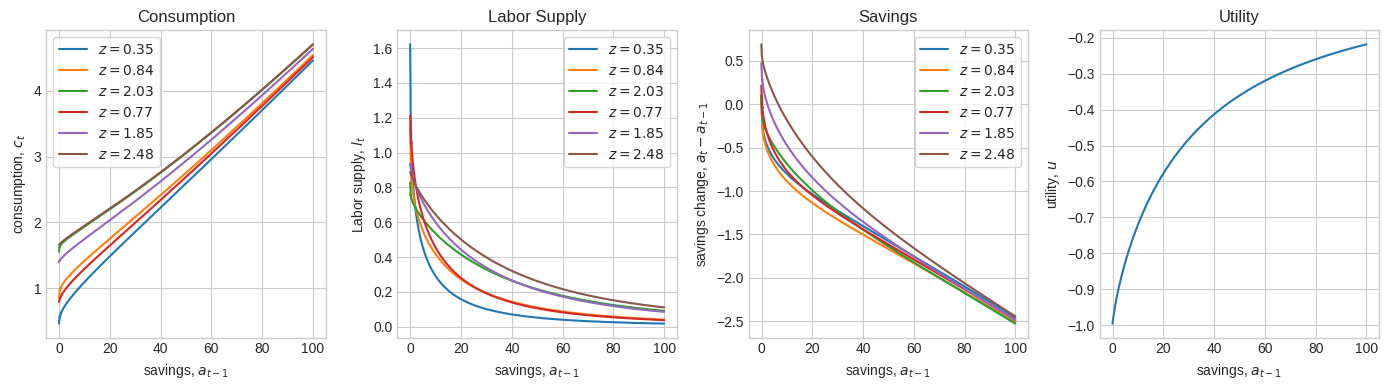

In [5]:
fig = plt.figure(figsize=(14,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,4,1)
ax.set_title(f'Consumption')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.c[i_z, :][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.legend(frameon=True)

# Labor Supply
ax = fig.add_subplot(1,4,2)
ax.set_title(f'Labor Supply')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.l[i_z, :][I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('Labor supply, $l_t$')
ax.legend(frameon=True)


# Labor Supply
ax = fig.add_subplot(1,4,3)
ax.set_title(f'Savings')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.a[i_z, :][I]-par.a_grid[I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_t - a_{t-1}$')
ax.legend(frameon=True)

# Labor Supply
ax = fig.add_subplot(1,4,4)
ax.set_title(f'Utility')

# for i_z, z in enumerate(par.z_grid):
#     if i_z % 3 == 0 or i_z == par.Nz-1:
ax.plot(par.a_grid[I], sol.u[-1][I]
        # ,label=f'$z={z:.2f}$'
        )

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('utility, $u$')
# ax.legend(frameon=True)

fig.tight_layout()
plt.plot()

In [ ]:
par.beta_grid

In [ ]:
fig = plt.figure(figsize=(10,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,1,1)
ax.set_title(f'Consumption')

for i_z, z in enumerate(par.beta_grid):
    # if i_z % 3 == 0 or i_z == par.Nbeta-1:
    ax.plot(par.a_grid[I], sol.c[i_z, :][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.legend(frameon=True)

In [ ]:
tau_vec = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
U = np.zeros(len(tau_vec))
L = np.zeros(len(tau_vec))
C = np.zeros(len(tau_vec))
A = np.zeros(len(tau_vec))

for i, tau in enumerate(tau_vec):
    model_tau = ConSavModelClass(name='range',par={'tau':tau})
    model_tau.solve(do_print=False,algo='egm')
    L[i] = np.mean(model_tau.sol.l)
    U[i] = np.mean(model_tau.sol.u)
    C[i] = np.mean(model_tau.sol.c)
    A[i] = np.mean(model_tau.sol.a)

In [ ]:
fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,4,1)
ax.set_title('Average  Utility, $u$')
ax.plot(tau_vec,U,'-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(1,4,2)
ax.set_title('labor supply, $l$')
ax.plot(tau_vec,L,'-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(1,4,3)
ax.set_title('consumption, $c$')
ax.plot(tau_vec,C,'-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(1,4,4)
ax.set_title('savings, $a$')
ax.plot(tau_vec,A,'-')
ax.set_xlabel('$\\tau$')

In [ ]:
model.simulate(algo='mc', do_print=True)

In [ ]:
# Calculate the mean of a and l for each period
a_mean = sim.a.mean(axis=1)
l_mean = sim.l.mean(axis=1)
c_mean = sim.c.mean(axis=1)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

# a. consumption
ax[0].plot(np.arange(par.simT), c_mean)
ax[0].set_title('Simulated Consumption')
ax[0].set_xlabel('Simulated Periods, $t$')
ax[0].set_ylabel('Mean Consumption, $c_t$')


# b. labor supply
ax[1].plot(np.arange(par.simT), l_mean)
ax[1].set_title('Simulated Labor Supply')
ax[1].set_xlabel('Simulated Periods, $t$')
ax[1].set_ylabel('Mean Labor Supply, $l_t$')

# b. savings
ax[2].plot(np.arange(par.simT), a_mean)
ax[2].set_title('Simulated Savings')
ax[2].set_xlabel('Simulated Periods, $t$')
ax[2].set_ylabel('Mean Savings, $a_t$')

fig.tight_layout()
plt.show()